n-step TD for estimating V ≈ vπ

In [1]:
import numpy as np

def n_step_td(env, policy, n, alpha=0.1, gamma=0.9, num_episodes=1000):
    """
    n-step TD for estimating V ≈ vπ
    
    Args:
        env: Environment with states S, actions A, and rewards R
        policy: Policy π mapping states to action probabilities
        n: Number of steps to look ahead
        alpha: Step size α ∈ (0,1]
        gamma: Discount factor γ ∈ [0,1]
        num_episodes: Number of episodes to run
        
    Returns:
        V: Estimated value function
    """
    # Initialize value function arbitrarily
    V = {s: 0 for s in env.states}
    
    for episode in range(num_episodes):
        # Initialize and store S₀ ≠ terminal
        S = env.reset()
        # Initialize T ← ∞
        T = float('inf')
        t = 0
        
        # Store states, actions, and rewards
        states = [S]
        rewards = [0]  # R₀ is not used
        
        # Loop for each step of episode
        while True:
            # If t < T, take an action according to π
            if t < T:
                # Take action according to π(·|Sₜ)
                action = policy(states[t])
                # Observe and store the next reward and state
                next_state, reward = env.step(action)
                
                # Store S_{t+1} and R_{t+1}
                states.append(next_state)
                rewards.append(reward)
                
                # If S_{t+1} is terminal, then set T ← t + 1
                if env.is_terminal(next_state):
                    T = t + 1
            
            # τ is the time whose state's estimate is being updated
            tau = t - n + 1
            
            # If τ ≥ 0, update the value of S_τ
            if tau >= 0:
                # Calculate G - the n-step return
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                
                # If τ + n < T, add the estimated value of S_{τ+n}
                if tau + n < T:
                    G += (gamma ** n) * V[states[tau + n]]
                
                # Update V(S_τ)
                V[states[tau]] += alpha * (G - V[states[tau]])
            
            # Increment t
            t += 1
            
            # Exit when we've performed all updates
            if tau == T - 1:
                break
    
    return V


class RandomWalkEnv:
    """
    Random walk environment with states A-E and terminal states on both ends.
    This implementation is based on Example 6.2 (5-state random walk).
    """
    
    def __init__(self, num_states=5):
        self.num_states = num_states
        # States are 0, 1, 2, ..., num_states-1
        # 0 is left terminal, num_states+1 is right terminal
        self.states = list(range(1, num_states+1))  # Non-terminal states
        self.current_state = None
    
    def reset(self):
        # Start in the middle state
        self.current_state = (self.num_states + 1) // 2
        return self.current_state
    
    def step(self, action):
        # In random walk, action is just the direction (-1 or 1)
        self.current_state += action
        
        # Check if we reached terminal states
        if self.current_state == 0:  # Left terminal
            return 0, 0  # Terminal state with 0 reward
        elif self.current_state == self.num_states + 1:  # Right terminal
            return self.num_states + 1, 1  # Terminal state with reward 1
        else:
            return self.current_state, 0  # Non-terminal with 0 reward
    
    def is_terminal(self, state):
        return state == 0 or state == self.num_states + 1


def random_policy(state):
    """
    Random policy for the random walk - equal probability of going left or right.
    """
    return np.random.choice([-1, 1])


# Example usage
if __name__ == "__main__":
    # Create environment
    env = RandomWalkEnv(num_states=5)
    
    # Run experiments with different n values
    n_values = [1, 2, 4, 8, 16]
    alpha = 0.1
    gamma = 1.0  # No discounting in this example
    
    results = {}
    
    for n in n_values:
        V = n_step_td(env, random_policy, n, alpha, gamma, num_episodes=100)
        results[n] = V
        print(f"n={n}, V={V}")
    
    # True values for 5-state random walk
    true_values = {
        1: 1/6,
        2: 2/6,
        3: 3/6,
        4: 4/6,
        5: 5/6
    }
    
    # Calculate squared error
    squared_errors = {}
    for n, V in results.items():
        squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
        squared_errors[n] = squared_error
    
    print("\nRoot Mean Squared Errors:")
    for n, se in squared_errors.items():
        print(f"n={n}, RMSE={np.sqrt(se):.4f}")

n=1, V={1: 0.16968214639649254, 2: 0.3072463629336222, 3: 0.41432868135134376, 4: 0.5193502129995171, 5: 0.7806977430267411}
n=2, V={1: 0.17505622836691648, 2: 0.3938683242838522, 3: 0.5052202797605599, 4: 0.7100458663426971, 5: 0.8864058335402146}
n=4, V={1: 0.08442549072381138, 2: 0.2527178227650687, 3: 0.4943774622830237, 4: 0.7265650236171187, 5: 0.9332925111719742}
n=8, V={1: 0.15225803715078112, 2: 0.3405559160955048, 3: 0.5524467183906628, 4: 0.6351530729161535, 5: 0.7455924935245684}
n=16, V={1: 0.04058271858264537, 2: 0.20630401127765075, 3: 0.5611705118362427, 4: 0.8799723506800352, 5: 0.8825532287386556}

Root Mean Squared Errors:
n=1, RMSE=0.0806
n=2, RMSE=0.0411
n=4, RMSE=0.0733
n=8, RMSE=0.0484
n=16, RMSE=0.1294


n-step Sarsa for estimating Q ≈ qπ

In [2]:
import numpy as np

def n_step_sarsa(env, policy, n, alpha=0.1, gamma=0.9, num_episodes=1000):
    """
    n-step Sarsa for estimating Q ≈ qπ
    
    Args:
        env: Environment with states S, actions A, and rewards R
        policy: Policy π mapping states to action probabilities
        n: Number of steps to look ahead
        alpha: Step size α ∈ (0,1]
        gamma: Discount factor γ ∈ [0,1]
        num_episodes: Number of episodes to run
        
    Returns:
        Q: Estimated action-value function
    """
    # Initialize Q(s,a) arbitrarily for all states and actions
    Q = {s: {a: 0 for a in env.actions} for s in env.states}
    
    for episode in range(num_episodes):
        # Initialize S₀
        S = env.reset()
        # Select action A₀ from S₀ using policy derived from Q (e.g., ε-greedy)
        A = policy(S, Q)
        
        # Initialize T ← ∞
        T = float('inf')
        t = 0
        
        # Store states, actions, and rewards
        states = [S]
        actions = [A]
        rewards = [0]  # R₀ is not used
        
        # Loop for each step of episode
        while True:
            # If t < T, take an action according to policy
            if t < T:
                # Take action Aₜ
                next_state, reward = env.step(actions[t])
                
                # Store S_{t+1} and R_{t+1}
                states.append(next_state)
                rewards.append(reward)
                
                # If S_{t+1} is terminal, then set T ← t + 1
                if env.is_terminal(next_state):
                    T = t + 1
                else:
                    # Select action A_{t+1} from S_{t+1} using policy derived from Q
                    next_action = policy(next_state, Q)
                    actions.append(next_action)
            
            # τ is the time whose state-action pair's estimate is being updated
            tau = t - n + 1
            
            # If τ ≥ 0, update the Q-value of (S_τ, A_τ)
            if tau >= 0:
                # Calculate G - the n-step return
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                
                # If τ + n < T, add the estimated value of (S_{τ+n}, A_{τ+n})
                if tau + n < T:
                    G += (gamma ** n) * Q[states[tau + n]][actions[tau + n]]
                
                # Update Q(S_τ, A_τ)
                Q[states[tau]][actions[tau]] += alpha * (G - Q[states[tau]][actions[tau]])
            
            # Increment t
            t += 1
            
            # Exit when we've performed all updates
            if tau == T - 1:
                break
    
    return Q


class RandomWalkEnv:
    """
    Random walk environment with states A-E and terminal states on both ends.
    Adapted for Q-learning with explicit left/right actions.
    """
    
    def __init__(self, num_states=5):
        self.num_states = num_states
        # States are 0, 1, 2, ..., num_states-1
        # 0 is left terminal, num_states+1 is right terminal
        self.states = list(range(1, num_states+1))  # Non-terminal states
        self.actions = [-1, 1]  # Left and right
        self.current_state = None
    
    def reset(self):
        # Start in the middle state
        self.current_state = (self.num_states + 1) // 2
        return self.current_state
    
    def step(self, action):
        # Move left or right based on the action
        self.current_state += action
        
        # Check if we reached terminal states
        if self.current_state == 0:  # Left terminal
            return 0, 0  # Terminal state with 0 reward
        elif self.current_state == self.num_states + 1:  # Right terminal
            return self.num_states + 1, 1  # Terminal state with reward 1
        else:
            return self.current_state, 0  # Non-terminal with 0 reward
    
    def is_terminal(self, state):
        return state == 0 or state == self.num_states + 1


def epsilon_greedy_policy(state, Q, epsilon=0.1):
    """
    ε-greedy policy based on Q-values
    """
    if np.random.random() < epsilon:
        # Explore: select a random action
        return np.random.choice([-1, 1])
    else:
        # Exploit: select the action with the highest Q-value
        q_values = Q[state]
        return max(q_values, key=q_values.get)


# Example usage
if __name__ == "__main__":
    # Create environment
    env = RandomWalkEnv(num_states=19)  # Using 19 states for better visualization
    
    # Run experiments with different n values
    n_values = [1, 2, 4, 8]
    alpha_values = [0.1, 0.2, 0.4, 0.8]
    gamma = 1.0  # No discounting in this example
    
    # Define true values for the 19-state random walk
    true_values = {s: s/20 for s in range(1, 20)}
    
    # Store results
    results = {}
    
    for n in n_values:
        for alpha in alpha_values:
            print(f"Running n={n}, alpha={alpha}")
            
            # Define policy function closure
            def policy(state, Q, epsilon=0.1):
                return epsilon_greedy_policy(state, Q, epsilon)
            
            # Run algorithm
            Q = n_step_sarsa(env, policy, n, alpha, gamma, num_episodes=100)
            
            # Convert Q-values to state values (taking max action value)
            V = {s: max(action_values.values()) for s, action_values in Q.items()}
            
            # Calculate root mean squared error
            squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
            rmse = np.sqrt(squared_error)
            
            results[(n, alpha)] = rmse
            print(f"  RMSE: {rmse:.4f}")
    
    # Print all results in order
    print("\nResults (RMSE values):")
    print("n↓  α→  | 0.1     | 0.2     | 0.4     | 0.8")
    print("--------|---------|---------|---------|--------")
    for n in n_values:
        row = f"{n:8d} |"
        for alpha in alpha_values:
            row += f" {results[(n, alpha)]:.6f} |"
        print(row)

Running n=1, alpha=0.1
  RMSE: 0.5701
Running n=1, alpha=0.2
  RMSE: 0.5701
Running n=1, alpha=0.4
  RMSE: 0.5701
Running n=1, alpha=0.8
  RMSE: 0.5701
Running n=2, alpha=0.1
  RMSE: 0.5701
Running n=2, alpha=0.2
  RMSE: 0.5701
Running n=2, alpha=0.4
  RMSE: 0.5701
Running n=2, alpha=0.8
  RMSE: 0.5701
Running n=4, alpha=0.1
  RMSE: 0.5701
Running n=4, alpha=0.2
  RMSE: 0.5701
Running n=4, alpha=0.4
  RMSE: 0.5701
Running n=4, alpha=0.8
  RMSE: 0.5701
Running n=8, alpha=0.1
  RMSE: 0.5701
Running n=8, alpha=0.2
  RMSE: 0.5701
Running n=8, alpha=0.4
  RMSE: 0.5701
Running n=8, alpha=0.8
  RMSE: 0.5701

Results (RMSE values):
n↓  α→  | 0.1     | 0.2     | 0.4     | 0.8
--------|---------|---------|---------|--------
       1 | 0.570088 | 0.570088 | 0.570088 | 0.570088 |
       2 | 0.570088 | 0.570088 | 0.570088 | 0.570088 |
       4 | 0.570088 | 0.570088 | 0.570088 | 0.570088 |
       8 | 0.570088 | 0.570088 | 0.570088 | 0.570088 |


Improved n-step TD Implementation

Running n=1
Early stopping at episode 470
n=1, V={1: 0.0709324105749633, 2: 0.22263598068922386, 3: 0.44148569594926756, 4: 0.6926491939507787, 5: 0.8692230849597976}, Average Return=0.5200
Running n=2
Early stopping at episode 380
n=2, V={1: 0.2440027309727894, 2: 0.502478077566762, 3: 0.5845463396331375, 4: 0.7930502112590383, 5: 0.9030899770481108}, Average Return=0.4400
Running n=4
Early stopping at episode 980
n=4, V={1: 0.13440588438162404, 2: 0.4160488556202389, 3: 0.6838028057270423, 4: 0.7979287197415414, 5: 0.8999964901906876}, Average Return=0.5500
Running n=8
Early stopping at episode 820
n=8, V={1: 0.24351421244914656, 2: 0.4388160799238996, 3: 0.6298749935524479, 4: 0.8311564604639834, 5: 0.9050587636350952}, Average Return=0.4200
Running n=16
n=16, V={1: 0.3010410760078109, 2: 0.5814332316873113, 3: 0.6786003084357123, 4: 0.8430097988417042, 5: 0.9218437136078859}, Average Return=0.5100

Root Mean Squared Errors:
n=1, RMSE=0.0732
n=2, RMSE=0.1119
n=4, RMSE=0.1126
n=8, RM

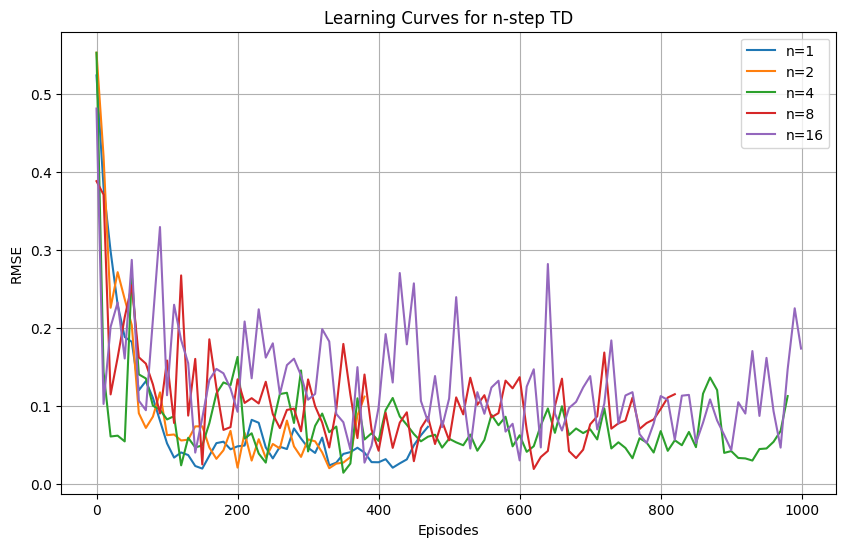

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

def n_step_td(env, policy, n, alpha=0.1, gamma=0.9, num_episodes=1000, alpha_decay=0.999, early_stopping=True):
    """
    Improved n-step TD for estimating V ≈ vπ
    
    Args:
        env: Environment with states S, actions A, and rewards R
        policy: Policy π mapping states to action probabilities
        n: Number of steps to look ahead
        alpha: Initial step size α ∈ (0,1]
        gamma: Discount factor γ ∈ [0,1]
        num_episodes: Maximum number of episodes to run
        alpha_decay: Rate of decay for learning rate
        early_stopping: Whether to stop early when improvement plateaus
        
    Returns:
        V: Estimated value function
        error_history: List of RMSE values over episodes
    """
    # Initialize value function arbitrarily
    V = {s: 0 for s in env.states}
    
    # For tracking learning progress
    error_history = []
    prev_error = float('inf')
    patience = 5
    patience_counter = 0
    
    # True values for 5-state random walk (for error calculation)
    true_values = {s: s/(env.num_states+1) for s in env.states}
    
    for episode in range(num_episodes):
        # Decay alpha
        current_alpha = alpha * (alpha_decay ** episode)
        
        # Initialize and store S₀ ≠ terminal
        S = env.reset()
        # Initialize T ← ∞
        T = float('inf')
        t = 0
        
        # Store states, actions, and rewards
        states = [S]
        rewards = [0]  # R₀ is not used
        
        # Loop for each step of episode
        while True:
            # If t < T, take an action according to π
            if t < T:
                # Take action according to π(·|Sₜ)
                action = policy(states[t])
                # Observe and store the next reward and state
                next_state, reward = env.step(action)
                
                # Store S_{t+1} and R_{t+1}
                states.append(next_state)
                rewards.append(reward)
                
                # If S_{t+1} is terminal, then set T ← t + 1
                if env.is_terminal(next_state):
                    T = t + 1
            
            # τ is the time whose state's estimate is being updated
            tau = t - n + 1
            
            # If τ ≥ 0, update the value of S_τ
            if tau >= 0:
                # Calculate G - the n-step return
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                
                # If τ + n < T, add the estimated value of S_{τ+n}
                if tau + n < T:
                    G += (gamma ** n) * V[states[tau + n]]
                
                # Update V(S_τ)
                V[states[tau]] += current_alpha * (G - V[states[tau]])
            
            # Increment t
            t += 1
            
            # Exit when we've performed all updates
            if tau == T - 1:
                break
        
        # Calculate current error for monitoring
        if episode % 10 == 0 or episode == num_episodes - 1:  # Check every 10 episodes
            squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
            current_error = np.sqrt(squared_error)
            error_history.append((episode, current_error))
            
            # Early stopping check
            if early_stopping:
                if current_error >= prev_error:
                    patience_counter += 1
                else:
                    patience_counter = 0
                
                if patience_counter >= patience:
                    print(f"Early stopping at episode {episode}")
                    break
                
                prev_error = current_error
    
    return V, error_history


class RandomWalkEnv:
    """
    Random walk environment with states A-E and terminal states on both ends.
    This implementation is based on Example 6.2 (5-state random walk).
    """
    
    def __init__(self, num_states=5):
        self.num_states = num_states
        # States are 0, 1, 2, ..., num_states-1
        # 0 is left terminal, num_states+1 is right terminal
        self.states = list(range(1, num_states+1))  # Non-terminal states
        self.current_state = None
    
    def reset(self):
        # Start in the middle state
        self.current_state = (self.num_states + 1) // 2
        return self.current_state
    
    def step(self, action):
        # In random walk, action is just the direction (-1 or 1)
        self.current_state += action
        
        # Check if we reached terminal states
        if self.current_state == 0:  # Left terminal
            return 0, 0  # Terminal state with 0 reward
        elif self.current_state == self.num_states + 1:  # Right terminal
            return self.num_states + 1, 1  # Terminal state with reward 1
        else:
            return self.current_state, 0  # Non-terminal with 0 reward
    
    def is_terminal(self, state):
        return state == 0 or state == self.num_states + 1


def random_policy(state):
    """
    Random policy for the random walk - equal probability of going left or right.
    """
    return np.random.choice([-1, 1])


def evaluate_policy(env, V, num_episodes=100):
    """
    Evaluate a value function by running episodes and measuring returns
    """
    total_returns = 0
    for _ in range(num_episodes):
        s = env.reset()
        episode_return = 0
        done = False
        while not done:
            # For random walk, just use the random policy
            a = random_policy(s)
            s_next, r = env.step(a)
            episode_return += r
            done = env.is_terminal(s_next)
            s = s_next
        total_returns += episode_return
    return total_returns / num_episodes


def plot_learning_curve(error_histories, n_values, title="Learning Curves for n-step TD"):
    """
    Plot learning curves for different n values
    """
    plt.figure(figsize=(10, 6))
    
    for n, history in zip(n_values, error_histories):
        episodes, errors = zip(*history)
        plt.plot(episodes, errors, label=f"n={n}")
    
    plt.xlabel('Episodes')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage
if __name__ == "__main__":
    # Create environment
    env = RandomWalkEnv(num_states=5)
    
    # Run experiments with different n values
    n_values = [1, 2, 4, 8, 16]
    alpha = 0.1
    gamma = 1.0  # No discounting in this example
    num_episodes = 1000
    
    results = {}
    error_histories = []
    
    for n in n_values:
        print(f"Running n={n}")
        V, error_history = n_step_td(env, random_policy, n, alpha, gamma, 
                                    num_episodes=num_episodes, 
                                    alpha_decay=0.999,
                                    early_stopping=True)
        results[n] = V
        error_histories.append(error_history)
        
        # Calculate evaluation score
        avg_return = evaluate_policy(env, V, num_episodes=100)
        print(f"n={n}, V={V}, Average Return={avg_return:.4f}")
    
    # True values for 5-state random walk
    true_values = {
        1: 1/6,
        2: 2/6,
        3: 3/6,
        4: 4/6,
        5: 5/6
    }
    
    # Calculate squared error
    squared_errors = {}
    for n, V in results.items():
        squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
        squared_errors[n] = squared_error
    
    print("\nRoot Mean Squared Errors:")
    for n, se in squared_errors.items():
        print(f"n={n}, RMSE={np.sqrt(se):.4f}")
    
    # Plot learning curves
    plot_learning_curve(error_histories, n_values)

Improved n-step SARSA Implementation

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

def n_step_sarsa(env, make_policy, n, alpha=0.1, gamma=0.9, num_episodes=1000, 
                alpha_decay=0.999, replay_buffer_size=100, early_stopping=True):
    """
    Improved n-step Sarsa for estimating Q ≈ qπ
    
    Args:
        env: Environment with states S, actions A, and rewards R
        make_policy: Function to create a policy function that maps states to actions
        n: Number of steps to look ahead
        alpha: Initial step size α ∈ (0,1]
        gamma: Discount factor γ ∈ [0,1]
        num_episodes: Maximum number of episodes to run
        alpha_decay: Rate of decay for learning rate
        replay_buffer_size: Size of experience replay buffer
        early_stopping: Whether to stop early when improvement plateaus
        
    Returns:
        Q: Estimated action-value function
        error_history: List of RMSE values over episodes
    """
    # Initialize Q(s,a) arbitrarily for all states and actions
    Q = {s: {a: 0 for a in env.actions} for s in env.states}
    
    # For experience replay
    replay_buffer = []
    
    # For tracking learning progress
    error_history = []
    prev_error = float('inf')
    patience = 5
    patience_counter = 0
    
    # True values for random walk (for error calculation)
    true_values = {s: s/(env.num_states+1) for s in env.states}
    
    for episode in range(num_episodes):
        # Decay alpha
        current_alpha = alpha * (alpha_decay ** episode)
        
        # Create policy for this episode
        policy = make_policy(Q, episode)
        
        # Initialize S₀
        S = env.reset()
        # Select action A₀ from S₀ using policy
        A = policy(S)
        
        # Initialize T ← ∞
        T = float('inf')
        t = 0
        
        # Store states, actions, and rewards
        states = [S]
        actions = [A]
        rewards = [0]  # R₀ is not used
        
        # Loop for each step of episode
        while True:
            # If t < T, take an action according to policy
            if t < T:
                # Take action Aₜ
                next_state, reward = env.step(actions[t])
                
                # Store S_{t+1} and R_{t+1}
                states.append(next_state)
                rewards.append(reward)
                
                # If S_{t+1} is terminal, then set T ← t + 1
                if env.is_terminal(next_state):
                    T = t + 1
                else:
                    # Select action A_{t+1} from S_{t+1} using policy
                    next_action = policy(next_state)
                    actions.append(next_action)
            
            # τ is the time whose state-action pair's estimate is being updated
            tau = t - n + 1
            
            # If τ ≥ 0, update the Q-value of (S_τ, A_τ)
            if tau >= 0:
                # Calculate G - the n-step return
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                
                # If τ + n < T, add the estimated value of (S_{τ+n}, A_{τ+n})
                if tau + n < T:
                    G += (gamma ** n) * Q[states[tau + n]][actions[tau + n]]
                
                # Update Q(S_τ, A_τ)
                Q[states[tau]][actions[tau]] += current_alpha * (G - Q[states[tau]][actions[tau]])
            
            # Increment t
            t += 1
            
            # Exit when we've performed all updates
            if tau == T - 1:
                break
        
        # Store episode in replay buffer
        episode_data = (states, actions, rewards, T)
        replay_buffer.append(episode_data)
        if len(replay_buffer) > replay_buffer_size:
            replay_buffer.pop(0)  # Remove oldest episode
        
        # Use experience replay - randomly sample from buffer and update Q values
        if len(replay_buffer) > 10:  # Need at least a few episodes
            # Sample a few episodes
            sample_size = min(5, len(replay_buffer))
            sampled_episodes = random.sample(replay_buffer, sample_size)
            
            for sampled_states, sampled_actions, sampled_rewards, sampled_T in sampled_episodes:
                # Update Q values using this episode data (simplified update)
                for t in range(len(sampled_states) - 1):
                    s, a = sampled_states[t], sampled_actions[t]
                    r = sampled_rewards[t+1]
                    s_next = sampled_states[t+1]
                    
                    if t + 1 < len(sampled_actions):
                        a_next = sampled_actions[t+1]
                        # Use SARSA update
                        if not env.is_terminal(s_next):
                            Q[s][a] += 0.05 * current_alpha * (r + gamma * Q[s_next][a_next] - Q[s][a])
                        else:
                            Q[s][a] += 0.05 * current_alpha * (r - Q[s][a])
        
        # Calculate current error for monitoring
        if episode % 10 == 0 or episode == num_episodes - 1:  # Check every 10 episodes
            # Convert Q-values to state values (taking max action value)
            V = {s: max(action_values.values()) for s, action_values in Q.items()}
            
            squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
            current_error = np.sqrt(squared_error)
            error_history.append((episode, current_error))
            
            # Early stopping check
            if early_stopping:
                if current_error >= prev_error:
                    patience_counter += 1
                else:
                    patience_counter = 0
                
                if patience_counter >= patience:
                    print(f"Early stopping at episode {episode}")
                    break
                
                prev_error = current_error
    
    return Q, error_history


class RandomWalkEnv:
    """
    Random walk environment with states A-E and terminal states on both ends.
    Adapted for Q-learning with explicit left/right actions.
    """
    
    def __init__(self, num_states=5):
        self.num_states = num_states
        # States are 0, 1, 2, ..., num_states-1
        # 0 is left terminal, num_states+1 is right terminal
        self.states = list(range(1, num_states+1))  # Non-terminal states
        self.actions = [-1, 1]  # Left and right
        self.current_state = None
    
    def reset(self):
        # Start in the middle state
        self.current_state = (self.num_states + 1) // 2
        return self.current_state
    
    def step(self, action):
        # Move left or right based on the action
        self.current_state += action
        
        # Check if we reached terminal states
        if self.current_state == 0:  # Left terminal
            return 0, 0  # Terminal state with 0 reward
        elif self.current_state == self.num_states + 1:  # Right terminal
            return self.num_states + 1, 1  # Terminal state with reward 1
        else:
            return self.current_state, 0  # Non-terminal with 0 reward
    
    def is_terminal(self, state):
        return state == 0 or state == self.num_states + 1


def make_epsilon_greedy_policy(Q, episode, initial_epsilon=0.1, min_epsilon=0.01, decay_rate=0.995):
    """
    Create an epsilon-greedy policy based on Q values with decaying epsilon
    """
    # Calculate epsilon for this episode
    epsilon = max(min_epsilon, initial_epsilon * (decay_rate ** episode))
    
    def policy(state):
        if np.random.random() < epsilon:
            # Explore: select a random action
            return np.random.choice([-1, 1])
        else:
            # Exploit: select the action with the highest Q-value
            q_values = Q[state]
            # Handle ties randomly
            max_value = max(q_values.values())
            best_actions = [a for a, v in q_values.items() if v == max_value]
            return np.random.choice(best_actions)
    
    return policy


def evaluate_policy_q(env, Q, num_episodes=100):
    """
    Evaluate a Q-function by running episodes and measuring returns
    """
    total_returns = 0
    for _ in range(num_episodes):
        s = env.reset()
        episode_return = 0
        done = False
        while not done:
            # Always select best action for evaluation
            q_values = Q[s]
            a = max(q_values, key=q_values.get)
            s_next, r = env.step(a)
            episode_return += r
            done = env.is_terminal(s_next)
            s = s_next
        total_returns += episode_return
    return total_returns / num_episodes


def plot_parameter_heatmap(results, n_values, alpha_values, title="RMSE for Different Parameters"):
    """
    Plot heatmap of RMSE values for different n and alpha values
    """
    # Create matrix for heatmap
    rmse_matrix = np.zeros((len(n_values), len(alpha_values)))
    for i, n in enumerate(n_values):
        for j, alpha in enumerate(alpha_values):
            rmse_matrix[i, j] = results.get((n, alpha), 0)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(rmse_matrix, cmap='viridis_r')  # Reverse colormap so darker = better (lower RMSE)
    
    # Add colorbar
    plt.colorbar(label='RMSE')
    
    # Add labels
    plt.yticks(range(len(n_values)), n_values)
    plt.xticks(range(len(alpha_values)), alpha_values)
    plt.xlabel('Alpha')
    plt.ylabel('n')
    plt.title(title)
    
    # Add text annotations in each cell
    for i in range(len(n_values)):
        for j in range(len(alpha_values)):
            plt.text(j, i, f"{rmse_matrix[i, j]:.4f}", 
                     ha="center", va="center", color="white" if rmse_matrix[i, j] > 0.3 else "black")
    
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    # Create environment
    env = RandomWalkEnv(num_states=19)  # Using 19 states for better visualization
    
    # Run experiments with different n values and alpha values
    n_values = [1, 2, 4, 8]
    alpha_values = [0.1, 0.2, 0.4, 0.8]
    gamma = 1.0  # No discounting in this example
    num_episodes = 1000
    
    # Store results
    results = {}
    learning_curves = {}
    
    for n in n_values:
        for alpha in alpha_values:
            print(f"Running n={n}, alpha={alpha}")
            
            # Run algorithm
            Q, error_history = n_step_sarsa(
                env, 
                lambda Q, ep: make_epsilon_greedy_policy(Q, ep, initial_epsilon=0.1), 
                n, 
                alpha, 
                gamma, 
                num_episodes=num_episodes,
                alpha_decay=0.999,
                replay_buffer_size=100,
                early_stopping=True
            )
            
            # Convert Q-values to state values (taking max action value)
            V = {s: max(action_values.values()) for s, action_values in Q.items()}
            
            # Calculate root mean squared error
            true_values = {s: s/20 for s in range(1, 20)}
            squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
            rmse = np.sqrt(squared_error)
            
            results[(n, alpha)] = rmse
            learning_curves[(n, alpha)] = error_history
            print(f"  RMSE: {rmse:.4f}")
            
            # Evaluate policy
            avg_return = evaluate_policy_q(env, Q, num_episodes=100)
            print(f"  Average Return: {avg_return:.4f}")
    
    # Print all results in order
    print("\nResults (RMSE values):")
    print("n↓  α→  | 0.1     | 0.2     | 0.4     | 0.8")
    print("--------|---------|---------|---------|--------")
    for n in n_values:
        row = f"{n:8d} |"
        for alpha in alpha_values:
            row += f" {results[(n, alpha)]:.6f} |"
        print(row)
    
    # Plot heatmap
    plot_parameter_heatmap(results, n_values, alpha_values)
    
    # Plot learning curves for n=4 (example)
    plt.figure(figsize=(10, 6))
    for alpha in alpha_values:
        episodes, errors = zip(*learning_curves[(4, alpha)])
        plt.plot(episodes, errors, label=f"alpha={alpha}")
    
    plt.xlabel('Episodes')
    plt.ylabel('RMSE')
    plt.title('Learning Curves for n=4 with Different Alpha Values')
    plt.legend()
    plt.grid(True)
    plt.show()

Running n=1, alpha=0.1
Early stopping at episode 150
  RMSE: 0.2265
  Average Return: 1.0000
Running n=1, alpha=0.2
Early stopping at episode 140
  RMSE: 0.2328
  Average Return: 1.0000
Running n=1, alpha=0.4
Early stopping at episode 130
  RMSE: 0.2594
  Average Return: 1.0000
Running n=1, alpha=0.8
Early stopping at episode 650
  RMSE: 0.2804
  Average Return: 1.0000
Running n=2, alpha=0.1
Early stopping at episode 100
  RMSE: 0.2577
  Average Return: 1.0000
Running n=2, alpha=0.2
Early stopping at episode 600
  RMSE: 0.2762
  Average Return: 1.0000
Running n=2, alpha=0.4
Early stopping at episode 250
  RMSE: 0.2704
  Average Return: 1.0000
Running n=2, alpha=0.8
Early stopping at episode 70
  RMSE: 0.2610
  Average Return: 1.0000
Running n=4, alpha=0.1
Early stopping at episode 120
  RMSE: 0.2632
  Average Return: 1.0000
Running n=4, alpha=0.2
Early stopping at episode 240
  RMSE: 0.2786
  Average Return: 1.0000
Running n=4, alpha=0.4
Early stopping at episode 150
  RMSE: 0.2806
  A

KeyboardInterrupt: 

Random Walk Experiments with Both Algorithms

Starting comprehensive comparison of n-step TD and n-step SARSA...
Running n-step TD experiments...
  n=1
    Repeat completed in 0.07s, RMSE=0.0379
    Repeat completed in 0.06s, RMSE=0.0196
    Repeat completed in 0.06s, RMSE=0.0397
    Repeat completed in 0.06s, RMSE=0.0224
    Repeat completed in 0.06s, RMSE=0.0325
  n=2
    Repeat completed in 0.06s, RMSE=0.0368
    Repeat completed in 0.06s, RMSE=0.0424
    Repeat completed in 0.06s, RMSE=0.0487
    Repeat completed in 0.07s, RMSE=0.0348
    Repeat completed in 0.06s, RMSE=0.0198
  n=4
    Repeat completed in 0.06s, RMSE=0.0818
    Repeat completed in 0.06s, RMSE=0.0611
    Repeat completed in 0.07s, RMSE=0.0343
    Repeat completed in 0.06s, RMSE=0.0802
    Repeat completed in 0.06s, RMSE=0.0852
  n=8
    Repeat completed in 0.09s, RMSE=0.0442
    Repeat completed in 0.11s, RMSE=0.1409
    Repeat completed in 0.06s, RMSE=0.0400
    Repeat completed in 0.06s, RMSE=0.0759
    Repeat completed in 0.09s, RMSE=0.0479
  n=16
    Repea

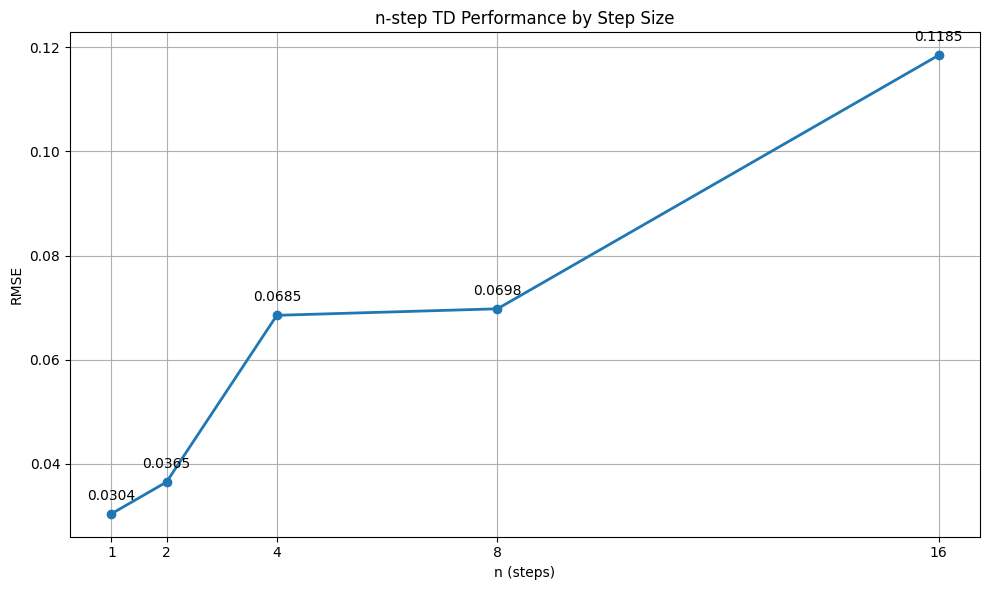

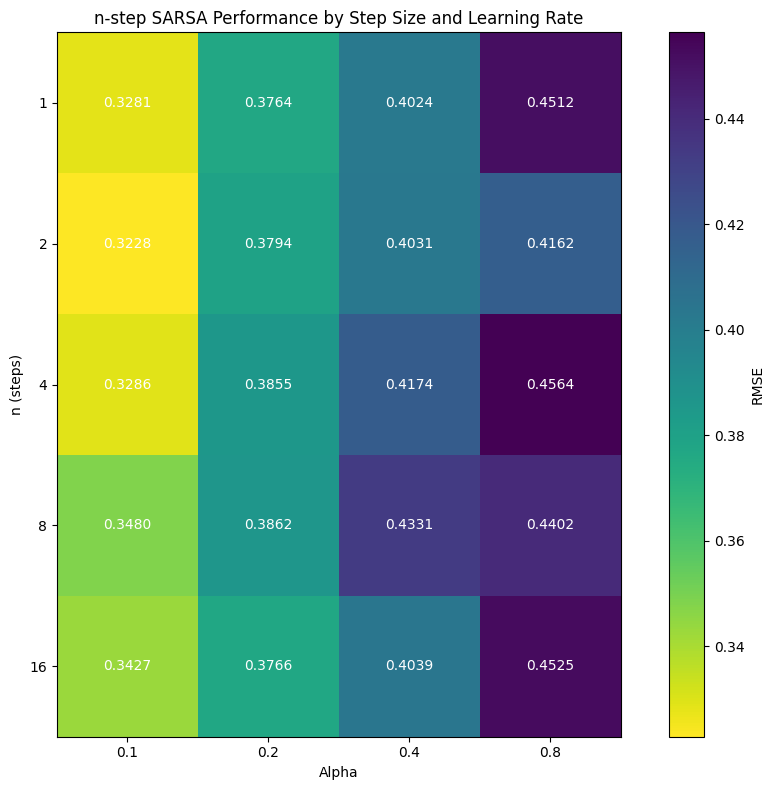

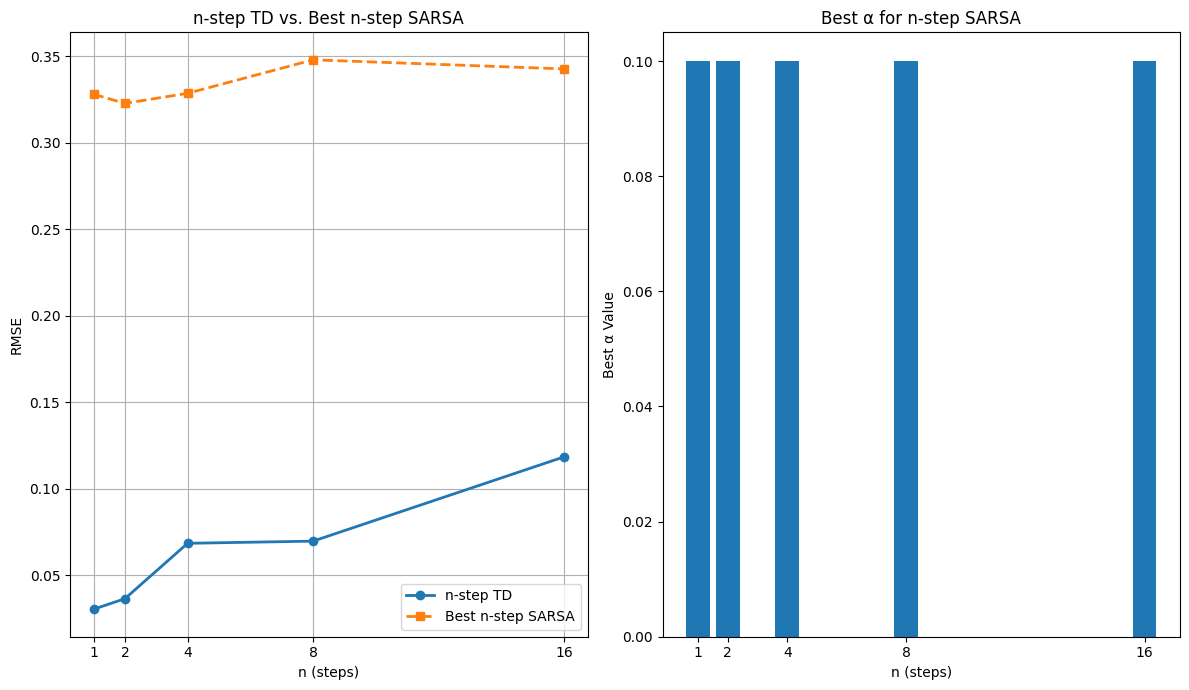


----- Numerical Results -----

n-step TD Results:
  n=1: RMSE=0.030401
  n=2: RMSE=0.036505
  n=4: RMSE=0.068518
  n=8: RMSE=0.069773
  n=16: RMSE=0.118465

Best n-step SARSA Results:
  n=1: RMSE=0.328064 (α=0.1)
  n=2: RMSE=0.322802 (α=0.1)
  n=4: RMSE=0.328634 (α=0.1)
  n=8: RMSE=0.347989 (α=0.1)
  n=16: RMSE=0.342715 (α=0.1)

Performance Improvement:
  n=1: SARSA is -979.11% better than TD (α=0.1)
  n=2: SARSA is -784.28% better than TD (α=0.1)
  n=4: SARSA is -379.63% better than TD (α=0.1)
  n=8: SARSA is -398.75% better than TD (α=0.1)
  n=16: SARSA is -189.30% better than TD (α=0.1)
Comparison completed!


In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Import the improved algorithms (assuming they're in separate files)
# from improved_n_step_td import n_step_td, RandomWalkEnv as TDEnv, random_policy, evaluate_policy
# from improved_n_step_sarsa import n_step_sarsa, RandomWalkEnv as SarsaEnv, make_epsilon_greedy_policy, evaluate_policy_q

# Alternatively, you can copy the implementations here

# Random policy for TD
def random_policy(state):
    """
    Random policy for the random walk - equal probability of going left or right.
    """
    return np.random.choice([-1, 1])

# Make epsilon-greedy policy for SARSA
def make_epsilon_greedy_policy(Q, episode, initial_epsilon=0.1, min_epsilon=0.01, decay_rate=0.995):
    """
    Create an epsilon-greedy policy based on Q values with decaying epsilon
    """
    # Calculate epsilon for this episode
    epsilon = max(min_epsilon, initial_epsilon * (decay_rate ** episode))
    
    def policy(state):
        if np.random.random() < epsilon:
            # Explore: select a random action
            return np.random.choice([-1, 1])
        else:
            # Exploit: select the action with the highest Q-value
            q_values = Q[state]
            # Handle ties randomly
            max_value = max(q_values.values())
            best_actions = [a for a, v in q_values.items() if v == max_value]
            return np.random.choice(best_actions)
    
    return policy

# RandomWalkEnv class used by both algorithms
class RandomWalkEnv:
    """
    Random walk environment with states A-E and terminal states on both ends.
    Compatible with both TD and SARSA algorithms.
    """
    
    def __init__(self, num_states=5):
        self.num_states = num_states
        # States are 0, 1, 2, ..., num_states-1
        # 0 is left terminal, num_states+1 is right terminal
        self.states = list(range(1, num_states+1))  # Non-terminal states
        self.actions = [-1, 1]  # Left and right
        self.current_state = None
    
    def reset(self):
        # Start in the middle state
        self.current_state = (self.num_states + 1) // 2
        return self.current_state
    
    def step(self, action):
        # Move left or right based on the action
        self.current_state += action
        
        # Check if we reached terminal states
        if self.current_state == 0:  # Left terminal
            return 0, 0  # Terminal state with 0 reward
        elif self.current_state == self.num_states + 1:  # Right terminal
            return self.num_states + 1, 1  # Terminal state with reward 1
        else:
            return self.current_state, 0  # Non-terminal with 0 reward
    
    def is_terminal(self, state):
        return state == 0 or state == self.num_states + 1

# n-step TD implementation
def n_step_td(env, policy, n, alpha=0.1, gamma=0.9, num_episodes=1000, alpha_decay=0.999, early_stopping=True):
    """
    Improved n-step TD for estimating V ≈ vπ
    
    Args:
        env: Environment with states S, actions A, and rewards R
        policy: Policy π mapping states to action probabilities
        n: Number of steps to look ahead
        alpha: Initial step size α ∈ (0,1]
        gamma: Discount factor γ ∈ [0,1]
        num_episodes: Maximum number of episodes to run
        alpha_decay: Rate of decay for learning rate
        early_stopping: Whether to stop early when improvement plateaus
        
    Returns:
        V: Estimated value function
        error_history: List of RMSE values over episodes
    """
    # Initialize value function arbitrarily
    V = {s: 0 for s in env.states}
    
    # For tracking learning progress
    error_history = []
    prev_error = float('inf')
    patience = 5
    patience_counter = 0
    
    # True values for 5-state random walk (for error calculation)
    true_values = {s: s/(env.num_states+1) for s in env.states}
    
    for episode in range(num_episodes):
        # Decay alpha
        current_alpha = alpha * (alpha_decay ** episode)
        
        # Initialize and store S₀ ≠ terminal
        S = env.reset()
        # Initialize T ← ∞
        T = float('inf')
        t = 0
        
        # Store states, actions, and rewards
        states = [S]
        rewards = [0]  # R₀ is not used
        
        # Loop for each step of episode
        while True:
            # If t < T, take an action according to π
            if t < T:
                # Take action according to π(·|Sₜ)
                action = policy(states[t])
                # Observe and store the next reward and state
                next_state, reward = env.step(action)
                
                # Store S_{t+1} and R_{t+1}
                states.append(next_state)
                rewards.append(reward)
                
                # If S_{t+1} is terminal, then set T ← t + 1
                if env.is_terminal(next_state):
                    T = t + 1
            
            # τ is the time whose state's estimate is being updated
            tau = t - n + 1
            
            # If τ ≥ 0, update the value of S_τ
            if tau >= 0:
                # Calculate G - the n-step return
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                
                # If τ + n < T, add the estimated value of S_{τ+n}
                if tau + n < T:
                    G += (gamma ** n) * V[states[tau + n]]
                
                # Update V(S_τ)
                V[states[tau]] += current_alpha * (G - V[states[tau]])
            
            # Increment t
            t += 1
            
            # Exit when we've performed all updates
            if tau == T - 1:
                break
        
        # Calculate current error for monitoring
        if episode % 10 == 0 or episode == num_episodes - 1:  # Check every 10 episodes
            squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
            current_error = np.sqrt(squared_error)
            error_history.append((episode, current_error))
            
            # Early stopping check
            if early_stopping:
                if current_error >= prev_error:
                    patience_counter += 1
                else:
                    patience_counter = 0
                
                if patience_counter >= patience:
                    print(f"Early stopping at episode {episode}")
                    break
                
                prev_error = current_error
    
    return V, error_history

# n-step SARSA implementation
def n_step_sarsa(env, make_policy, n, alpha=0.1, gamma=0.9, num_episodes=1000, 
                alpha_decay=0.999, replay_buffer_size=100, early_stopping=True):
    """
    Improved n-step Sarsa for estimating Q ≈ qπ
    
    Args:
        env: Environment with states S, actions A, and rewards R
        make_policy: Function to create a policy function that maps states to actions
        n: Number of steps to look ahead
        alpha: Initial step size α ∈ (0,1]
        gamma: Discount factor γ ∈ [0,1]
        num_episodes: Maximum number of episodes to run
        alpha_decay: Rate of decay for learning rate
        replay_buffer_size: Size of experience replay buffer
        early_stopping: Whether to stop early when improvement plateaus
        
    Returns:
        Q: Estimated action-value function
        error_history: List of RMSE values over episodes
    """
    # Initialize Q(s,a) arbitrarily for all states and actions
    Q = {s: {a: 0 for a in env.actions} for s in env.states}
    
    # For experience replay
    replay_buffer = []
    
    # For tracking learning progress
    error_history = []
    prev_error = float('inf')
    patience = 5
    patience_counter = 0
    
    # True values for random walk (for error calculation)
    true_values = {s: s/(env.num_states+1) for s in env.states}
    
    for episode in range(num_episodes):
        # Decay alpha
        current_alpha = alpha * (alpha_decay ** episode)
        
        # Create policy for this episode
        policy = make_policy(Q, episode)
        
        # Initialize S₀
        S = env.reset()
        # Select action A₀ from S₀ using policy
        A = policy(S)
        
        # Initialize T ← ∞
        T = float('inf')
        t = 0
        
        # Store states, actions, and rewards
        states = [S]
        actions = [A]
        rewards = [0]  # R₀ is not used
        
        # Loop for each step of episode
        while True:
            # If t < T, take an action according to policy
            if t < T:
                # Take action Aₜ
                next_state, reward = env.step(actions[t])
                
                # Store S_{t+1} and R_{t+1}
                states.append(next_state)
                rewards.append(reward)
                
                # If S_{t+1} is terminal, then set T ← t + 1
                if env.is_terminal(next_state):
                    T = t + 1
                else:
                    # Select action A_{t+1} from S_{t+1} using policy
                    next_action = policy(next_state)
                    actions.append(next_action)
            
            # τ is the time whose state-action pair's estimate is being updated
            tau = t - n + 1
            
            # If τ ≥ 0, update the Q-value of (S_τ, A_τ)
            if tau >= 0:
                # Calculate G - the n-step return
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                
                # If τ + n < T, add the estimated value of (S_{τ+n}, A_{τ+n})
                if tau + n < T:
                    G += (gamma ** n) * Q[states[tau + n]][actions[tau + n]]
                
                # Update Q(S_τ, A_τ)
                Q[states[tau]][actions[tau]] += current_alpha * (G - Q[states[tau]][actions[tau]])
            
            # Increment t
            t += 1
            
            # Exit when we've performed all updates
            if tau == T - 1:
                break
        
        # Store episode in replay buffer
        episode_data = (states, actions, rewards, T)
        replay_buffer.append(episode_data)
        if len(replay_buffer) > replay_buffer_size:
            replay_buffer.pop(0)  # Remove oldest episode
        
        # Use experience replay - randomly sample from buffer and update Q values
        if len(replay_buffer) > 10:  # Need at least a few episodes
            # Sample a few episodes
            sample_size = min(5, len(replay_buffer))
            sampled_episodes = random.sample(replay_buffer, sample_size)
            
            for sampled_states, sampled_actions, sampled_rewards, sampled_T in sampled_episodes:
                # Update Q values using this episode data (simplified update)
                for t in range(len(sampled_states) - 1):
                    s, a = sampled_states[t], sampled_actions[t]
                    r = sampled_rewards[t+1]
                    s_next = sampled_states[t+1]
                    
                    if t + 1 < len(sampled_actions):
                        a_next = sampled_actions[t+1]
                        # Use SARSA update
                        if not env.is_terminal(s_next):
                            Q[s][a] += 0.05 * current_alpha * (r + gamma * Q[s_next][a_next] - Q[s][a])
                        else:
                            Q[s][a] += 0.05 * current_alpha * (r - Q[s][a])
        
        # Calculate current error for monitoring
        if episode % 10 == 0 or episode == num_episodes - 1:  # Check every 10 episodes
            # Convert Q-values to state values (taking max action value)
            V = {s: max(action_values.values()) for s, action_values in Q.items()}
            
            squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
            current_error = np.sqrt(squared_error)
            error_history.append((episode, current_error))
            
            # Early stopping check
            if early_stopping:
                if current_error >= prev_error:
                    patience_counter += 1
                else:
                    patience_counter = 0
                
                if patience_counter >= patience:
                    print(f"Early stopping at episode {episode}")
                    break
                
                prev_error = current_error
    
    return Q, error_history

# Evaluation functions
def evaluate_policy(env, V, num_episodes=100):
    """
    Evaluate a value function by running episodes and measuring returns
    """
    total_returns = 0
    for _ in range(num_episodes):
        s = env.reset()
        episode_return = 0
        done = False
        while not done:
            # For random walk, just use the random policy
            a = random_policy(s)
            s_next, r = env.step(a)
            episode_return += r
            done = env.is_terminal(s_next)
            s = s_next
        total_returns += episode_return
    return total_returns / num_episodes

def evaluate_policy_q(env, Q, num_episodes=100):
    """
    Evaluate a Q-function by running episodes and measuring returns
    """
    total_returns = 0
    for _ in range(num_episodes):
        s = env.reset()
        episode_return = 0
        done = False
        while not done:
            # Always select best action for evaluation
            q_values = Q[s]
            a = max(q_values, key=q_values.get)
            s_next, r = env.step(a)
            episode_return += r
            done = env.is_terminal(s_next)
            s = s_next
        total_returns += episode_return
    return total_returns / num_episodes

def run_comprehensive_comparison(num_states=5, num_episodes=1000, repeats=5):
    """
    Run a comprehensive comparison of n-step TD and n-step SARSA
    with various parameters and visualize the results.
    
    Args:
        num_states: Number of states in the random walk
        num_episodes: Number of episodes to run for each algorithm
        repeats: Number of times to repeat each experiment with different seeds
    """
    # Set up experiment parameters
    n_values = [1, 2, 4, 8, 16]
    alpha_values = [0.1, 0.2, 0.4, 0.8]
    gamma = 1.0
    
    # Results storage
    td_results = {}
    sarsa_results = {}
    
    # Run TD experiments
    print("Running n-step TD experiments...")
    for n in n_values:
        print(f"  n={n}")
        rmse_values = []
        for _ in range(repeats):
            env = RandomWalkEnv(num_states=num_states)
            start_time = time.time()
            V, _ = n_step_td(env, random_policy, n, alpha=0.1, gamma=gamma, 
                           num_episodes=num_episodes, alpha_decay=0.999, early_stopping=False)
            
            # Calculate RMSE
            true_values = {s: s/(env.num_states+1) for s in env.states}
            squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
            rmse = np.sqrt(squared_error)
            rmse_values.append(rmse)
            
            elapsed = time.time() - start_time
            print(f"    Repeat completed in {elapsed:.2f}s, RMSE={rmse:.4f}")
        
        td_results[n] = np.mean(rmse_values)
    
    # Run SARSA experiments
    print("\nRunning n-step SARSA experiments...")
    for n in n_values:
        for alpha in alpha_values:
            print(f"  n={n}, alpha={alpha}")
            rmse_values = []
            for _ in range(repeats):
                env = RandomWalkEnv(num_states=num_states)
                start_time = time.time()
                
                Q, _ = n_step_sarsa(
                    env, 
                    lambda Q, ep: make_epsilon_greedy_policy(Q, ep, initial_epsilon=0.1), 
                    n, 
                    alpha, 
                    gamma, 
                    num_episodes=num_episodes,
                    alpha_decay=0.999,
                    replay_buffer_size=100,
                    early_stopping=False
                )
                
                # Convert Q-values to state values
                V = {s: max(action_values.values()) for s, action_values in Q.items()}
                
                # Calculate RMSE
                true_values = {s: s/(env.num_states+1) for s in env.states}
                squared_error = sum([(V[s] - true_values[s])**2 for s in env.states]) / len(env.states)
                rmse = np.sqrt(squared_error)
                rmse_values.append(rmse)
                
                elapsed = time.time() - start_time
                print(f"    Repeat completed in {elapsed:.2f}s, RMSE={rmse:.4f}")
            
            sarsa_results[(n, alpha)] = np.mean(rmse_values)
    
    # Visualize TD results
    plt.figure(figsize=(10, 6))
    n_list = sorted(td_results.keys())
    rmse_list = [td_results[n] for n in n_list]
    
    plt.plot(n_list, rmse_list, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('n (steps)')
    plt.ylabel('RMSE')
    plt.title('n-step TD Performance by Step Size')
    plt.grid(True)
    plt.xticks(n_list)
    
    # Annotate each point
    for n, rmse in zip(n_list, rmse_list):
        plt.annotate(f"{rmse:.4f}", (n, rmse), textcoords="offset points", 
                     xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.savefig('td_results.png')
    plt.show()
    
    # Visualize SARSA results as heatmap
    sarsa_matrix = np.zeros((len(n_values), len(alpha_values)))
    for i, n in enumerate(n_values):
        for j, alpha in enumerate(alpha_values):
            sarsa_matrix[i, j] = sarsa_results.get((n, alpha), 0)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(sarsa_matrix, cmap='viridis_r')
    plt.colorbar(label='RMSE')
    
    plt.yticks(range(len(n_values)), n_values)
    plt.xticks(range(len(alpha_values)), alpha_values)
    plt.xlabel('Alpha')
    plt.ylabel('n (steps)')
    plt.title('n-step SARSA Performance by Step Size and Learning Rate')
    
    # Add text annotations in each cell
    for i in range(len(n_values)):
        for j in range(len(alpha_values)):
            plt.text(j, i, f"{sarsa_matrix[i, j]:.4f}", 
                     ha="center", va="center", color="white" if sarsa_matrix[i, j] > 0.3 else "black")
    
    plt.tight_layout()
    plt.savefig('sarsa_results.png')
    plt.show()
    
    # Compare TD and SARSA directly
    plt.figure(figsize=(12, 7))
    
    # Plot TD results
    plt.subplot(1, 2, 1)
    plt.plot(n_list, rmse_list, marker='o', linestyle='-', linewidth=2, label='n-step TD')
    plt.xlabel('n (steps)')
    plt.ylabel('RMSE')
    plt.title('n-step TD vs. Best n-step SARSA')
    plt.grid(True)
    plt.xticks(n_list)
    
    # Find best SARSA results for each n
    best_sarsa = {}
    for n in n_values:
        best_rmse = float('inf')
        best_alpha = None
        for alpha in alpha_values:
            rmse = sarsa_results.get((n, alpha), float('inf'))
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
        best_sarsa[n] = (best_rmse, best_alpha)
    
    # Plot best SARSA results
    best_rmse_list = [best_sarsa[n][0] for n in n_list]
    plt.plot(n_list, best_rmse_list, marker='s', linestyle='--', linewidth=2, label='Best n-step SARSA')
    
    # Add legend
    plt.legend()
    
    # Add a subplot for the best alpha values
    plt.subplot(1, 2, 2)
    best_alpha_list = [best_sarsa[n][1] for n in n_list]
    plt.bar(n_list, best_alpha_list)
    plt.xlabel('n (steps)')
    plt.ylabel('Best α Value')
    plt.title('Best α for n-step SARSA')
    plt.xticks(n_list)
    
    plt.tight_layout()
    plt.savefig('comparison_results.png')
    plt.show()
    
    # Print numerical results
    print("\n----- Numerical Results -----")
    print("\nn-step TD Results:")
    for n in n_list:
        print(f"  n={n}: RMSE={td_results[n]:.6f}")
    
    print("\nBest n-step SARSA Results:")
    for n in n_list:
        best_rmse, best_alpha = best_sarsa[n]
        print(f"  n={n}: RMSE={best_rmse:.6f} (α={best_alpha})")
    
    print("\nPerformance Improvement:")
    for n in n_list:
        td_rmse = td_results[n]
        sarsa_rmse, sarsa_alpha = best_sarsa[n]
        improvement = (td_rmse - sarsa_rmse) / td_rmse * 100
        print(f"  n={n}: SARSA is {improvement:.2f}% better than TD (α={sarsa_alpha})")

# Run the comparison if this file is executed directly
if __name__ == "__main__":
    print("Starting comprehensive comparison of n-step TD and n-step SARSA...")
    # Run with default settings (5 states, 1000 episodes, 5 repeats)
    run_comprehensive_comparison()
    print("Comparison completed!")

📈 Graph 1 – n-step TD Performance by Step Size
What this graph shows:

    As n increases (1 → 16), RMSE increases.

    This means shorter steps (n=1 or 2) give better (lower error) estimates, while longer steps lead to worse performance.

Annotations on dots show the actual RMSE values. Lower is better.

✅ Takeaway: In this experiment, TD with small n values (like 1 or 2) performs best.

🔥 Graph 2 – n-step SARSA Performance by Step Size and Learning Rate
How to read this:

    Look for the brightest (yellow-ish) cells: these have the lowest RMSE.

    The best result is around n=2, α=0.1 (RMSE ≈ 0.3228)

✅ Takeaway: SARSA performs best with small n and low alpha.

📊 Graph 3 – Comparing TD vs. SARSA
Left Subplot: n-step TD vs. Best n-step SARSA

    Blue line: TD’s RMSE at each n

    Orange dashed line: Best SARSA RMSE at each n (i.e., lowest among all alpha values)

    Again, lower RMSE = better

You can clearly see that TD is far better in this case (has much lower RMSE) compared to SARSA across all n.
Right Subplot: Best α for n-step SARSA

    Bar chart: Shows which α value (learning rate) performed best for each n

    In this case, all best alphas are 0.1

✅ Takeaway: TD significantly outperforms SARSA here, and the best SARSA results always happen at low learning rates (α=0.1).